In [1]:
# importing of all needed libraries and modules.  
%matplotlib inline
from math import sqrt
from pathlib import Path
from scipy import stats
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LassoLars, LinearRegression, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, PolynomialFeatures
import env
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings
import wrangle as w
warnings.filterwarnings("ignore")

In [2]:
# pull the data from the wrangle file
df=w.wrangle_zillow()

In [3]:
# split the data
train, validate, test = w.split_data(df)

In [4]:
# scale the data
train_scaled, validate_scaled, test_scaled=w.scale_data(train, validate, test)

In [5]:
# assign the train variables
X_train_scaled = train_scaled[['bedrooms','bathrooms', 'sq_feet']]
y_train=train[['logerror']]

In [6]:
#assign the validate variables
X_validate_scaled=validate_scaled[['bedrooms','bathrooms', 'sq_feet']]
y_validate=validate[['logerror']]

In [7]:
# assign the test variables
X_test_scaled=test_scaled[['bedrooms','bathrooms', 'sq_feet']]
y_test=test[['logerror']]

# BASELINE
Use rmse on both the mean and median.

In [8]:
# Create a function to get baseline.
def baseline(X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test):
    # We need y_train and y_validate (and test) to be dataframes to append the new columns with predicted values. 
    y_train = pd.DataFrame(y_train)
    y_validate = pd.DataFrame(y_validate)
    y_test = pd.DataFrame(y_test)

    # 1. Predict home_value_pred_mean
    logerror_pred_mean = y_train['logerror'].mean()
    y_train['logerror_pred_mean'] = logerror_pred_mean
    y_validate['logerror_pred_mean'] = logerror_pred_mean

    # 2. compute home_value_pred_median
    logerror_pred_median = y_train['logerror'].median()
    y_train['logerror_pred_median'] = logerror_pred_median
    y_validate['logerror_pred_median'] = logerror_pred_median

    # 3. RMSE of home_value_pred_mean
    rmse_train = mean_squared_error(y_train[['logerror']], y_train.logerror_pred_mean)**(1/2)
    rmse_validate = mean_squared_error(y_validate[['logerror']], y_validate.logerror_pred_mean)**(1/2)

    print("RMSE using Mean\nTrain/In-Sample: ", (rmse_train), 
      "\nValidate/Out-of-Sample: ", (rmse_validate))

    # 4. RMSE of home_value_pred_median
    rmse_train = mean_squared_error(y_train[['logerror']], y_train.logerror_pred_median)**(1/2)
    rmse_validate = mean_squared_error(y_validate[['logerror']], y_validate.logerror_pred_median)**(1/2)

    print("RMSE using Median\nTrain/In-Sample: ", (rmse_train), 
      "\nValidate/Out-of-Sample: ", (rmse_validate))
  

In [9]:
baseline(X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test)

RMSE using Mean
Train/In-Sample:  0.17111493570816058 
Validate/Out-of-Sample:  0.17619004134685448
RMSE using Median
Train/In-Sample:  0.17149111174671647 
Validate/Out-of-Sample:  0.17662277642319174


In [10]:
# create the model object
def ols():
    lm = LinearRegression(normalize=True)

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
    lm.fit(X_train_scaled, y_train.logerror)

    # predict train
    y_train['logerror_pred_lm'] = lm.predict(X_train_scaled)

    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(1/2)

    # predict validate
    y_validate['logerror_pred_lm'] = lm.predict(X_validate_scaled)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(1/2)

    print("RMSE for OLS\nTraining/In-Sample: ", rmse_train, 
          "\nValidation/Out-of-Sample: ", rmse_validate)

In [11]:
ols()

RMSE for OLS
Training/In-Sample:  0.17101605821415816 
Validation/Out-of-Sample:  0.1760599385357889


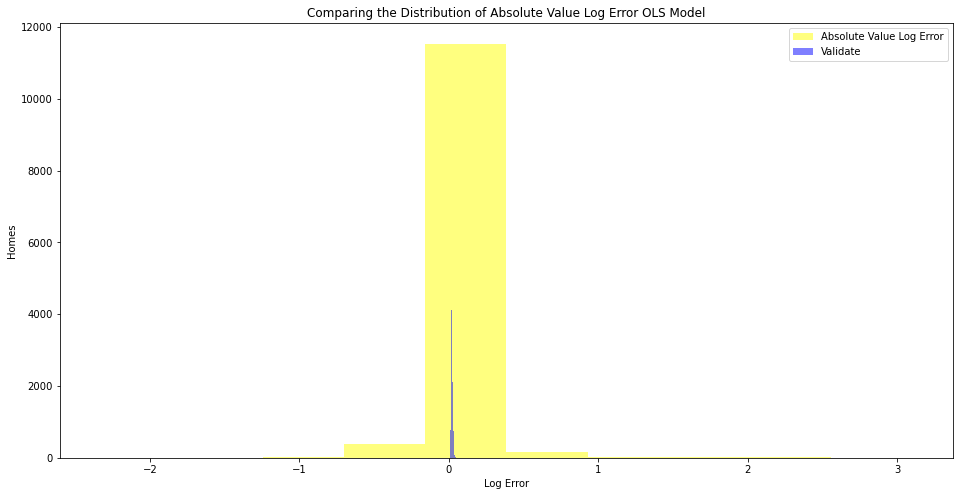

In [12]:

plt.figure(figsize=(16,8))
plt.hist(y_validate.logerror, color='yellow', alpha=.5, label="Absolute Value Log Error")
plt.hist(y_validate.logerror_pred_lm, color='blue', alpha=.5, label="Validate")
plt.xlabel("Log Error")
plt.ylabel("Homes")
plt.title("Comparing the Distribution of Absolute Value Log Error OLS Model")
plt.legend()
plt.show()



In [13]:
# create the polynomial regression model object

def poly():
    # make the polynomial features to get a new set of features
    pf = PolynomialFeatures(degree=2)

    # fit and transform X_train_scaled
    X_train_degree2 = pf.fit_transform(X_train_scaled)

    # transform X_validate_scaled & X_test_scaled
    X_validate_degree2 = pf.transform(X_validate_scaled)
    X_test_degree2 = pf.transform(X_test_scaled)

    # create the model object
    lm2 = LinearRegression(normalize=True)

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
    lm2.fit(X_train_degree2, y_train.logerror)

    # predict train
    y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2)**(1/2)

    # predict validate
    y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)**(1/2)

    print("RMSE for Poly 2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [14]:
poly()

RMSE for Poly 2
Training/In-Sample:  0.17099215888763386 
Validation/Out-of-Sample:  0.176063669620492


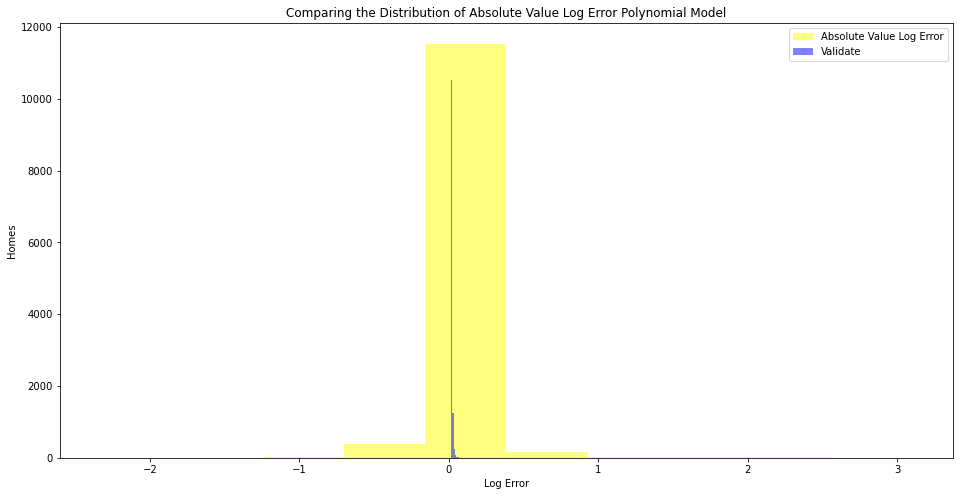

In [15]:

plt.figure(figsize=(16,8))
plt.hist(y_validate.logerror, color='yellow', alpha=.5, label="Absolute Value Log Error")
plt.hist(y_validate.logerror_pred_lm2, color='blue', alpha=.5, label="Validate")
plt.xlabel("Log Error")
plt.ylabel("Homes")
plt.title("Comparing the Distribution of Absolute Value Log Error Polynomial Model")
plt.legend()
plt.show()

In [16]:
#Create a function for the LassoLars regression model object

def lasso_lars():
    lars = LassoLars(alpha=1.0)

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
    lars.fit(X_train_scaled, y_train.logerror)

    # predict train
    y_train['logerror_pred_lars'] = lars.predict(X_train_scaled)

    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**(1/2)

    # predict validate
    y_validate['logerror_pred_lars'] = lars.predict(X_validate_scaled)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**(1/2)

    # predict test
    #y_test['logerror_pred_lars'] = lars.predict(X_test_scaled)

    # evaluate: rmse
    #rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_lars)**(1/2)

    print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
      #"\nTesting/Out-of-Sample Performance: ", rmse_test)


In [17]:
lasso_lars()

RMSE for Lasso + Lars
Training/In-Sample:  0.17111493570816058 
Validation/Out-of-Sample:  0.1761900413468545


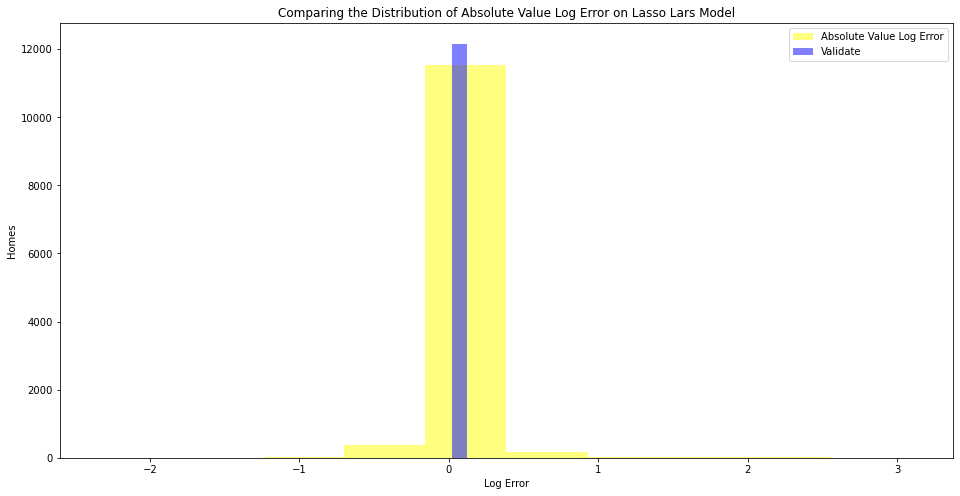

In [18]:
plt.figure(figsize=(16,8))
plt.hist(y_validate.logerror, color='yellow', alpha=.5, label="Absolute Value Log Error")
plt.hist(y_validate.logerror_pred_lars, color='blue', alpha=.5, label="Validate")
plt.xlabel("Log Error")
plt.ylabel("Homes")
plt.title("Comparing the Distribution of Absolute Value Log Error on Lasso Lars Model")
plt.legend()
plt.show()

In [19]:
#Create a function for the Tweedie regression model object
def tweedie():
    glm = TweedieRegressor(power=0, alpha=1)

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
    glm.fit(X_train_scaled, y_train.logerror)

    # predict train
    y_train['logerror_pred_glm'] = glm.predict(X_train_scaled)

    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_glm)**(1/2)

    # predict validate
    y_validate['logerror_pred_glm'] = glm.predict(X_validate_scaled)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_glm)**(1/2)

    # predict test
    #y_test['logerror_pred_glm'] = glm.predict(X_test_scaled)
    
    # evaluate: rmse
    #rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_glm)**(1/2)
    
    print("RMSE for Tweedie\nTraining/In-Sample: ", rmse_train,
          "\nValidation/Out-of-Sample: ", rmse_validate)
          #"\nTesting/Out-of-Sample Performance: ", rmse_test)

In [20]:
tweedie()

RMSE for Tweedie
Training/In-Sample:  0.1711068521696821 
Validation/Out-of-Sample:  0.17618126011791158


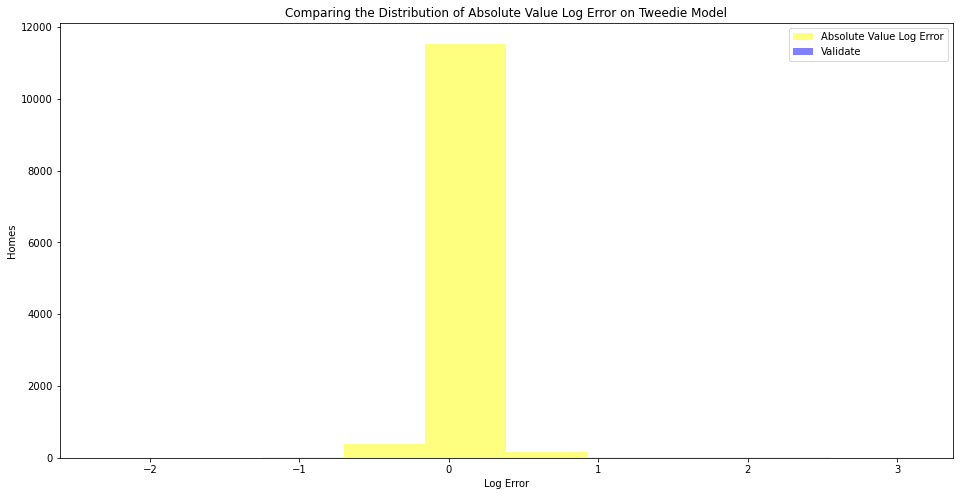

In [21]:

plt.figure(figsize=(16,8))
plt.hist(y_validate.logerror, color='yellow', alpha=.5, label="Absolute Value Log Error")
plt.hist(y_validate.logerror_pred_glm, color='blue', alpha=.5, label="Validate")
plt.xlabel("Log Error")
plt.ylabel("Homes")
plt.title("Comparing the Distribution of Absolute Value Log Error on Tweedie Model")
plt.legend()
plt.show()

Fit a linear regression model (ordinary least squares) and compute yhat, predictions of logerror.

In [22]:
evs = explained_variance_score(y_train.logerror, y_train.logerror_pred_lm)
print('The R2 or Explained Variance = ', round(evs,3))

The R2 or Explained Variance =  0.001


BEST MODEL IS OLS

In [23]:
# create the model object
def ols_test():
    lm = LinearRegression(normalize=True)

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
    lm.fit(X_train_scaled, y_train.logerror)

    # predict test
    y_test['logerror_pred_lm'] = lm.predict(X_test_scaled)

    # evaluate: rmse
    rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_lm)**(1/2)

    print("RMSE for OLS\nTesting/Out-of-Sample Performance: ", rmse_test)

   

In [24]:
ols_test()

RMSE for OLS
Testing/Out-of-Sample Performance:  0.17834418315463993


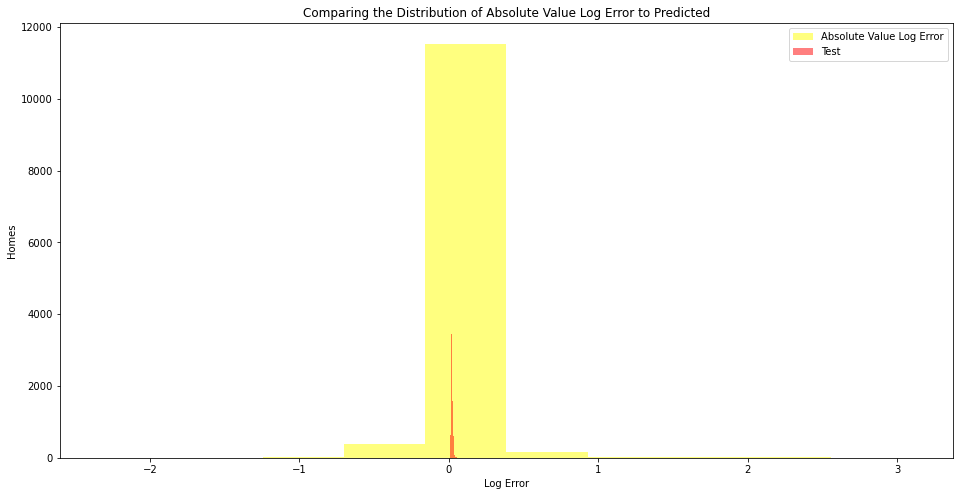

In [25]:
plt.figure(figsize=(16,8))
plt.hist(y_validate.logerror, color='yellow', alpha=.5, label="Absolute Value Log Error")
plt.hist(y_test.logerror_pred_lm, color='red', alpha=.5, label="Test")
plt.xlabel("Log Error")
plt.ylabel("Homes")
plt.title("Comparing the Distribution of Absolute Value Log Error to Predicted")
plt.legend()
plt.show()

In [26]:
y_train.head()

,logerror,logerror_pred_mean,logerror_pred_median,logerror_pred_lm,logerror_pred_lm2,logerror_pred_lars,logerror_pred_glm
40409,-0.001358,0.018335,0.006983,0.021460,0.017648,0.018335,0.018501
23172,0.044035,0.018335,0.006983,0.023857,0.021735,0.018335,0.018681
49707,0.026075,0.018335,0.006983,0.020795,0.020546,0.018335,0.018517
36587,-0.051115,0.018335,0.006983,0.018994,0.021205,0.018335,0.018495
6405,0.110311,0.018335,0.006983,0.013923,0.015742,0.018335,0.018219


There are some questions we need to answer:

1. How do we know if our model is good enough?
2. How do we find the line of best fit?
3. How do we evaluate our model?
4. Are our features valuable?